# **Carregando os Dados**

In [ ]:
import pandas as pd
import sqlite3 as sql

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/ABI Academy Hack/csv/data.csv"

In [ ]:
csv = pd.read_csv(file_path)

In [ ]:
#csv.head()

In [ ]:
conn = sql.connect('stocks.db')
cursor = conn.cursor()

In [ ]:
csv.to_sql('stocks', conn)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [ ]:
stocks = pd.read_sql('SELECT * FROM stocks', conn)
#stocks.head()

## **Entidades**

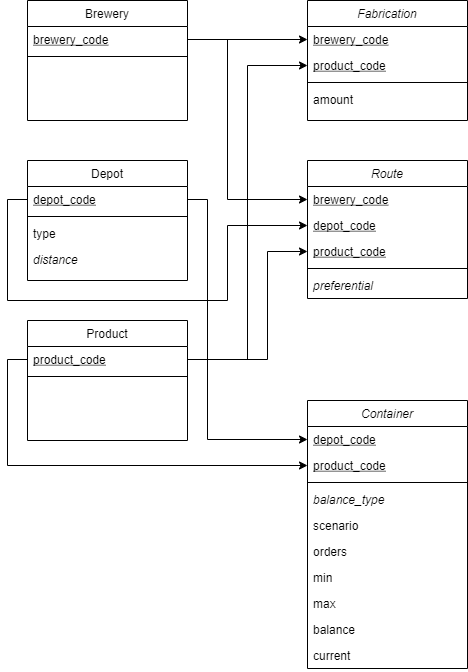

## **Cervejarias**

In [ ]:
query = "CREATE TABLE brewery (brewery_code text PRIMARY KEY);"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO brewery (brewery_code) SELECT DISTINCT "Supply Site Code" from stocks'
cursor.execute(query)

In [ ]:
breweries = pd.read_sql('SELECT * FROM brewery ORDER BY brewery_code', conn)
#breweries.head()

In [ ]:
breweries_values = breweries["brewery_code"].values

In [ ]:
breweries_count = breweries_values.shape[0]

In [ ]:
breweries_dict = dict(zip(breweries_values, range(len(breweries_values))))

## **Depósitos**

In [ ]:
query = "CREATE TABLE depot (depot_code text PRIMARY KEY, type text);"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO depot (depot_code, type) SELECT DISTINCT "Location Code", "Location Type" from stocks'
cursor.execute(query)

In [ ]:
depots = pd.read_sql('SELECT * FROM depot ORDER BY depot_code', conn)
#depots.head()

In [ ]:
depots_values = depots["depot_code"].values

In [ ]:
depots_count = depots_values.shape[0]

In [ ]:
depots_dict = dict(zip(depots_values, range(len(depots_values))))

## **Produtos**

In [ ]:
query = "CREATE TABLE product (product_code text PRIMARY KEY);"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO product (product_code) SELECT DISTINCT "SKU" from stocks'
cursor.execute(query)

In [ ]:
products = pd.read_sql('SELECT * FROM product ORDER BY product_code', conn)
#products.head()

## **Containers**

In [ ]:
query = "CREATE TABLE container (depot_code text, product_code text, scenario integer, orders integer, min real, max real, balance real, current real, PRIMARY KEY (depot_code, product_code));"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO container (depot_code, product_code, scenario, orders, min, max, balance, current) SELECT DISTINCT "Location Code", "SKU", "Scenario", "Distributor Orders", "MinDOC (Hl)", "MaxDOC (Hl)", "Reorder Point (Hl)", "Closing Stock" from stocks'
cursor.execute(query)

In [122]:
containers = pd.read_sql('SELECT * FROM container', conn)
#containers.head()

## **Fabricação**

In [ ]:
query = "CREATE TABLE fabrication (brewery_code text, product_code text, available real, PRIMARY KEY (brewery_code, product_code));"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO fabrication (brewery_code, product_code, available) SELECT DISTINCT "Supply Site Code", "SKU", "Available to Deploy" from stocks'
cursor.execute(query)

In [ ]:
fabrications = pd.read_sql('SELECT * FROM fabrication', conn)
#fabrications.head()

## **Rotas**

In [ ]:
query = "CREATE TABLE route (brewery_code text, depot_code text, product_code text, preferential integer, PRIMARY KEY (brewery_code, depot_code, product_code));"
cursor.execute(query)

In [ ]:
query = 'INSERT INTO route (brewery_code, depot_code, product_code, preferential) SELECT DISTINCT brewery_code, depot_code, product_code, 0 FROM brewery CROSS JOIN depot CROSS JOIN product;'
cursor.execute(query)

In [ ]:
query = 'INSERT OR REPLACE INTO route (brewery_code, depot_code, product_code, preferential) SELECT DISTINCT "Supply Site Code", "Location Code", "SKU", 1 from stocks;'
cursor.execute(query)

In [ ]:
routes = pd.read_sql('SELECT * FROM route', conn)
#routes.head()

# **Análise dos Dados**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

## **Distância**

### **Distância dos Pares**

Para as distâncias dos pares de cervejarias e depósitos, definiremos uma distância não euclidiana dada pela matriz de adjacencia que respeita a seguinte propriedade:

$\begin{align}
D_{i,j} = 1 - \frac{C_{i,j}}{\sum_{k = 0}^n C_{k,j}} 
\end{align}$

em que $C_{i,j}$ é a quantidade de tipos de produtos diferentes que a cervejaria $i$ serve ao depósito $j$. 


Como a distância que acabamos de definir é proporcional a distância euclidiana entre os depósitos e cervejarias, podemos usar essa medida para estimar as localizações reais deles. 

Pelo fato de termos um número pequeno de pares de distâncias não será possivel representar com alta precisão as localidades, contudo os clusters serão preservados e podem ter grande utilidade para a otimização do problema. 

In [ ]:
link_matrix = 2 * np.zeros([breweries_count, depots_count])
link_matrix.shape

(7, 57)

In [ ]:
connections = pd.read_sql('SELECT "Supply Site Code", "Location Code", COUNT(SKU) as weight FROM stocks GROUP BY "Supply Site Code", "Location Code" ORDER BY "Supply Site Code", "Location Code"', conn)
#connections.head()

In [ ]:
connections_values = connections.values

In [ ]:
for [brewery, depot, weight] in connections_values:
  i = breweries_dict[brewery]
  j = depots_dict[depot]
  link_matrix[i][j] = weight

In [ ]:
for j in range(link_matrix.shape[1]):
  total = 0
  for i in range(link_matrix.shape[0]):
    total += link_matrix[i][j]
  for i in range(link_matrix.shape[0]):
    link_matrix[i][j] /= total

In [ ]:
link_matrix = 1 - link_matrix 

### **Cervejarias**

Para obter as localizações das cervejarias irei obter as duas componentes principais da matriz de adjacência que definimos através do metódo MDS. 

Observando o plote de suas coordenadas é possivel concluir que as cervejarias estão espalhadas no território brasileiro.

In [ ]:
breweries_distance_MDS = MDS(n_components=2)
breweries_distance_matrix = breweries_distance_MDS.fit_transform(link_matrix)
breweries_distance_matrix.shape

(7, 2)

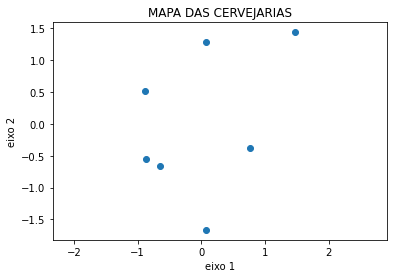

In [ ]:
plt.scatter(breweries_distance_matrix[:, 0], breweries_distance_matrix[:, 1])
plt.title("MAPA DAS CERVEJARIAS")
plt.xlabel("eixo 1")
plt.ylabel("eixo 2")
plt.axis("equal")
plt.show()

### **Depósitos**

Para obter as localizações dos depósitos irei obter as duas componentes principais da matriz transposta de adjacência que definimos através do metódo MDS. 

Através da utilização de cores diferentes para os depósitos e centros de distribuições é possivel observar que os centros de distribuição acompanham os depósitos. 

Alguns centros de distribuição aparecem na periferia, o que pode indicar a presença de outros depósitos ausentes na base da dados. 

Uma hipótese plausível é a base de dados se delimitar ao território brasileiro e esses centros estarem próximos da fronteira ao sul do país. 

In [ ]:
depots_distance_MDS = MDS(n_components=2)
depots_distance_matrix = depots_distance_MDS.fit_transform(link_matrix.T)
depots_distance_matrix.shape

(57, 2)

In [ ]:
depots_color = pd.read_sql('SELECT CASE type WHEN "DEP" THEN 0 ELSE 1 END FROM depot ORDER BY depot_code', conn)
depots_color = depots_color.values
depots_color = depots_color[:, 0]

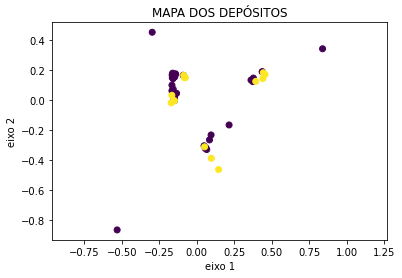

In [ ]:
plt.scatter(depots_distance_matrix[:, 0], depots_distance_matrix[:, 1], c=depots_color)
plt.title("MAPA DOS DEPÓSITOS")
plt.xlabel("eixo 1")
plt.ylabel("eixo 2")
plt.axis("equal")
plt.show()

### **Polos**

Observando o plote das coordenadas dos depósitos é possivel concluir que os depósitos estão espalhados em 4 polos diferentes. Esse número é confirmado também ao analisar o plote da soma das distâncias aos centroides dos clusters. Esses polos serão explorados futuramente no tratamentos dos dados.

In [ ]:
cluster_range = 9
all_kmeans = [KMeans(n_clusters=i+1) for i in range(cluster_range)]
for i in range(cluster_range):
    all_kmeans[i].fit(depots_distance_matrix)

inertias = [all_kmeans[i].inertia_ for i in range(cluster_range)]

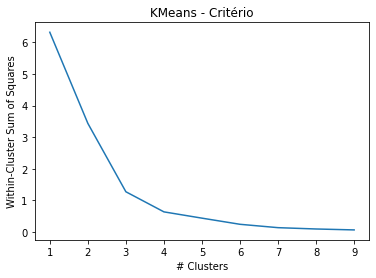

In [ ]:
plt.plot(np.arange(1, cluster_range + 1), inertias)
plt.title("KMeans - Critério")
plt.xlabel("# Clusters")
plt.ylabel("Within-Cluster Sum of Squares")
plt.show()

In [ ]:
depots_KMeans = KMeans(n_clusters=4)
depots_cluster = depots_KMeans.fit_predict(depots_distance_matrix)

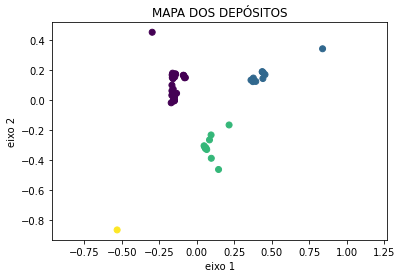

In [ ]:
plt.scatter(depots_distance_matrix[:, 0], depots_distance_matrix[:, 1], c=depots_cluster)
plt.title("MAPA DOS DEPÓSITOS")
plt.xlabel("eixo 1")
plt.ylabel("eixo 2")
plt.axis("equal")
plt.show()

## **Cenários**

In [ ]:
query = 'SELECT COUNT(*) as count FROM container GROUP BY scenario ORDER BY scenario'
scenario_count = pd.read_sql(query, conn)
scenario_count = scenario_count.values[:,0]

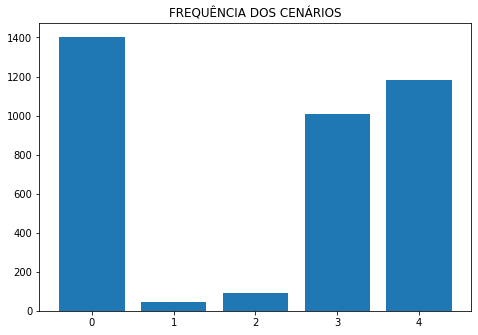

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["0", "1", "2", "3", "4"], scenario_count)
plt.title("FREQUÊNCIA DOS CENÁRIOS")
plt.show()

### **Funções Auxiliares**

In [ ]:
scenarios_subquery_start = 'SELECT product_code, SUM(available) as total_available from (SELECT DISTINCT brewery_code, product_code, available from route NATURAL JOIN fabrication NATURAL JOIN container WHERE preferential = 1 AND scenario = '
scenarios_subquery_end   = ') GROUP BY product_code'
scenarios_subquery = lambda x: scenarios_subquery_start + str(x) + scenarios_subquery_end

In [ ]:
scenarios_query_start = 'SELECT product_code, SUM(min) as total_min, SUM(balance) as total_balance, SUM(max) as total_max, SUM(current) as total_current, total_available, (SUM(current) + total_available) as total_possible FROM container NATURAL JOIN ('
scenarios_query_end   = lambda x: ') WHERE "scenario" = ' + str(x) + ' GROUP BY product_code' 
scenarios_query = lambda x : scenarios_query_start + scenarios_subquery(x) + scenarios_query_end(x)

In [ ]:
Round = lambda x, n: eval('"%.'+str(int(n))+'f" % '+repr(int(x)+round(float('.'+str(float(x)).split('.')[1]),n)))

In [ ]:
def compareValues(title, a, b):
    supply = a > b
    average = np.average(supply) * 100
    print(title + ": " + str(Round(average, 2)) + "%")

In [ ]:
def analyseScenario(df):
  values = df.values

  total_min = values[:, 1]
  total_balance = values[:, 2]
  total_max = values[:, 3]
  total_current = values[:, 4]
  total_available = values[:, 5]
  total_possible = values[:, 6]

  compareValues("total_current > total_max", total_current, total_max)
  compareValues("total_current > total_balance", total_current, total_balance)
  compareValues("total_current > total_min", total_current, total_min)
  print("")

  compareValues("total_available > total_max", total_available, total_max)
  compareValues("total_available > total_balance", total_available, total_balance)
  compareValues("total_available > total_min", total_available, total_min)
  print("")

  compareValues("total_possible > total_max", total_possible, total_max)
  compareValues("total_possible > total_balance", total_possible, total_balance)
  compareValues("total_possible > total_min", total_possible, total_min)

### **Cenário 0**

O Cenário 0 representa os containers que através das rotas usuais **não tem produtos disponíveis para receber das cervejarias**. 

Uma estratégia possível seria utilizar rotas alternativas, outra estratégia seria receber os produtos a partir de algum centro de distribuição que tem aquele produto em excesso. 

In [ ]:
scenario_0 = pd.read_sql(scenarios_query(0), conn)
#scenario_0.head()

In [ ]:
analyseScenario(scenario_0)

total_current > total_max: 17.39%
total_current > total_balance: 34.78%
total_current > total_min: 78.26%

total_available > total_max: 0.00%
total_available > total_balance: 0.00%
total_available > total_min: 0.00%

total_possible > total_max: 17.39%
total_possible > total_balance: 34.78%
total_possible > total_min: 78.26%


### **Cenário 1**

O Cenário 1 representa os containers que através das rotas usuais tem produtos disponíveis para receber das cervejarias que **ultrapassam o estoque máximo**.

In [ ]:
scenario_1 = pd.read_sql(scenarios_query(1), conn)
#scenario_1.head()

In [ ]:
analyseScenario(scenario_1)

total_current > total_max: 0.00%
total_current > total_balance: 0.00%
total_current > total_min: 100.00%

total_available > total_max: 100.00%
total_available > total_balance: 100.00%
total_available > total_min: 100.00%

total_possible > total_max: 100.00%
total_possible > total_balance: 100.00%
total_possible > total_min: 100.00%


### **Cenário 2**

O Cenário 2 representa os containers que através das rotas usuais tem produtos disponíveis para receber das cervejarias somados com a quantidade atual que **ultrapassam o estoque balanceado**.

In [ ]:
scenario_2 = pd.read_sql(scenarios_query(2), conn)
#scenario_2.head()

In [ ]:
analyseScenario(scenario_2)

total_current > total_max: 33.33%
total_current > total_balance: 66.67%
total_current > total_min: 100.00%

total_available > total_max: 0.00%
total_available > total_balance: 33.33%
total_available > total_min: 66.67%

total_possible > total_max: 33.33%
total_possible > total_balance: 100.00%
total_possible > total_min: 100.00%


### **Cenário 3**

O Cenário 3 representa os containers que através das rotas usuais tem produtos disponíveis para receber das cervejarias somados com a quantidade atual que **ultrapassam o estoque mínimo**.

Uma estratégia possível seria utilizar rotas alternativas, outra estratégia seria receber os produtos a partir de algum centro de distribuição que tem aquele produto em excesso. 

In [ ]:
scenario_3 = pd.read_sql(scenarios_query(3), conn)
#scenario_3.head()

In [ ]:
analyseScenario(scenario_3)

total_current > total_max: 5.56%
total_current > total_balance: 11.11%
total_current > total_min: 75.00%

total_available > total_max: 0.00%
total_available > total_balance: 0.00%
total_available > total_min: 88.89%

total_possible > total_max: 8.33%
total_possible > total_balance: 19.44%
total_possible > total_min: 100.00%


### **Cenário 4**

O Cenário 4 representa os containers que através das rotas usuais tem produtos disponíveis para receber das cervejarias somados com a quantidade atual que **não ultrapassam o estoque mínimo**.

Uma estratégia possível seria utilizar rotas alternativas, outra estratégia seria receber os produtos a partir de algum centro de distribuição que tem aquele produto em excesso. 

In [ ]:
scenario_4 = pd.read_sql(scenarios_query(4), conn)
#scenario_4.head()

In [ ]:
analyseScenario(scenario_4)

total_current > total_max: 0.00%
total_current > total_balance: 0.00%
total_current > total_min: 64.52%

total_available > total_max: 0.00%
total_available > total_balance: 0.00%
total_available > total_min: 0.00%

total_possible > total_max: 0.00%
total_possible > total_balance: 0.00%
total_possible > total_min: 70.97%


# **Tratamento dos Dados** 

## **Limpeza de Dados**

### **Filtrando Fabricações**

In [ ]:
query = 'DELETE FROM fabrication WHERE available = 0;'
cursor.execute(query)

In [ ]:
fabrications = pd.read_sql('SELECT * FROM fabrication ORDER BY brewery_code, product_code', conn)
#fabrications.head()

### **Filtrando Containers**

Removerei da tabela de containers os containers que possuirem alguma propriedade anormal, como a falta de informação sobre o estoque ou informações contraditórias sobre o estoque.

In [ ]:
query = 'DELETE FROM container WHERE max = 0 OR balance = 0;'
cursor.execute(query)

In [ ]:
query = 'DELETE FROM container WHERE max < balance OR max < min OR balance < min;'
cursor.execute(query)

In [ ]:
containers = pd.read_sql('SELECT * FROM container ORDER BY depot_code, product_code', conn)
#containers.head()

## **Enriquecimento dos Dados**

### **Containers**

#### **Tipos de Containers**

Adicionarei uma coluna na tabela de containers com informação sobre o atributo balance em relação a média dos atributos min e max.

In [ ]:
query = 'ALTER TABLE container ADD COLUMN balance_type integer';
cursor.execute(query)

In [ ]:
query = 'UPDATE container SET balance_type = 1 WHERE balance < (max + min) / 2 + 1 AND balance > (max + min) /2 - 1;'
cursor.execute(query)

In [ ]:
query = 'UPDATE container SET balance_type = 0 WHERE balance <= (max + min) / 2 + 1;'
cursor.execute(query)

In [ ]:
query = 'UPDATE container SET balance_type = 2 WHERE balance >= (max + min) / 2 - 1;'
cursor.execute(query)

In [ ]:
containers = pd.read_sql('SELECT * FROM container ORDER BY depot_code, product_code', conn)
#containers.head()

### **Depósitos**

#### **Distância**

Adicionarei uma coluna na tabela de depósitos com a distância daquele depósito ao polo (cluster) em que ele se encontra.

In [ ]:
depots_poles = depots_KMeans.cluster_centers_

In [ ]:
pole_distance = []
for i in range(len(depots_distance_matrix)):
  index = depots_cluster[i]
  pole = depots_poles[index]
  location = depots_distance_matrix[i]
  distance = np.linalg.norm(location - pole)
  pole_distance.append(distance)

In [ ]:
query = 'ALTER TABLE depot ADD COLUMN distance real';
cursor.execute(query)

In [ ]:
for i in range(len(depots_values)):
  depot_code = depots_values[i]
  distance = pole_distance[i]
  query = 'UPDATE depot SET distance = ' + str(distance) + ' WHERE depot_code = "' + str(depot_code) + '";'
  cursor.execute(query)

In [ ]:
color_distance = pd.read_sql('SELECT CASE WHEN distance > 0.3 THEN 0 WHEN distance > 0.1 THEN 1 WHEN distance > 0.05 THEN 2 ELSE 3 END color FROM depot ORDER BY depot_code', conn)
color_distance = color_distance.values
color_distance = color_distance[:,0]

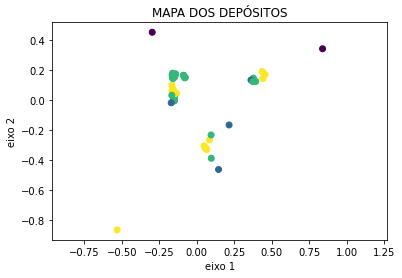

In [ ]:
plt.scatter(depots_distance_matrix[:, 0], depots_distance_matrix[:, 1], c=color_distance)
plt.title("MAPA DOS DEPÓSITOS")
plt.xlabel("eixo 1")
plt.ylabel("eixo 2")
plt.axis("equal")
plt.show()

# **Algoritmo Genético**

O algoritmo adotado para a resolução do problema será o algoritmo genético, com seus componentes explicados a seguir:

In [ ]:
import random
import math

## **Cromossomos**

Os cromossomos representam as diferentes escolhas para transportar os produtos das cervejarias aos estoques. Eles serão representados por genes de cervejarias e genes de depósitos atraves da seguinte configuração:

$
\text{Chromosome} = \begin{bmatrix}
    \text{Brewery}
    & 
    \text{Depot}
\end{bmatrix}
$

$\text{Chromosome} = \begin{bmatrix}
    \begin{bmatrix} 
     b_{1} \\
     b_{2} \\
     \vdots \\
     b_{m} \\
    \end{bmatrix}
    & 
    \begin{bmatrix}
    d_{11} & d_{12} & d_{13} & \dots  & d_{1n} \\
    d_{21} & d_{22} & d_{23} & \dots  & d_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    d_{m1} & d_{m2} & d_{m3} & \dots  & d_{mn}
\end{bmatrix}\end{bmatrix}$

em que $B$ é a matriz de genes de cervejarias e $D$ é a matriz de genes de depósitos.

### **Genes de Cervejaria**

A matriz coluna que representa os genes de cervejarias de um cromossomo é da seguinte forma:

$\text{Brewery} = 
\begin{bmatrix} 
     b_{1} \\
     b_{2} \\
     \vdots \\
     b_{m} \\
\end{bmatrix}
$

em que $b_i$ é a porcentagem dos produtos diponiveis da cervejária $i$ que serão utilizados para envio aos depósitos.

In [ ]:
def getBreweriesQuery(product_code):
  query_start = 'SELECT brewery_code, available FROM fabrication WHERE product_code = '
  query_end   = ' ORDER BY brewery_code;'
  return query_start + str(product_code) + query_end

In [ ]:
def getBreweries(product_code):
  fabrications = pd.read_sql(getBreweriesQuery(product_code), conn)
  return fabrications.values

### **Genes de Depósitos**

A matriz de adjacência que representa os genes de depósitos de um cromossomo é da seguinte forma:

$\text{Depot} = 
\begin{bmatrix}
    d_{11} & d_{12} & d_{13} & \dots  & d_{1n} \\
    d_{21} & u_{22} & d_{23} & \dots  & d_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    d_{m1} & d_{m2} & d_{m3} & \dots  & d_{mn}
\end{bmatrix}
$

em que $d_{i,j}$ é a porcentagem dos produtos que serão utilizados para envio a partir da cervejaria $i$ que será destinada ao depósito $j$.

In [ ]:
def getDepotsQuery(product_code):
  query_start = 'SELECT depot_code, current, min, balance, max FROM depot NATURAL JOIN container WHERE product_code = '
  query_end   = ' ORDER BY depot_code;'
  return query_start + str(product_code) + query_end

In [ ]:
def getDepots(product_code):
  containers = pd.read_sql(getDepotsQuery(product_code), conn)
  return containers.values

## **População**

$\text{Population} = 
\begin{bmatrix} 
     \text{Chromosome}^{(1)} \\
     \text{Chromosome}^{(2)} \\
     \vdots \\
     \text{Chromosome}^{(d)} \\
\end{bmatrix}
$, 

### **População Inicial**

In [ ]:
def randomChromosome(breweries_count, depots_count):
    breweries = np.random.rand(breweries_count, 1)
    depots    = np.random.rand(breweries_count, depots_count)
    depots    = depots / depots.sum(axis=1)[:, np.newaxis]
    return [breweries, depots]

In [ ]:
def randomPopulation(breweries_count, depots_count, size):
  population = []
  for i in range(size):
    population.append(randomChromosome(breweries_count, depots_count))
  return population

## **Função de Aptidão**

### **Váriaveis Auxiliares**

#### **Depósito**

##### **Depósito Atual**

A matriz que representa a quantidade atual em hectolitros de um produto específico em um depósito é da seguinte forma:

$\text{Current} = 
\begin{bmatrix} 
     c_{1} \\
     c_{2} \\
     \vdots \\
     c_{n} \\
\end{bmatrix}
$, 

em que $c_j$ significa a quantidade atual em hectolitros do depósito $j$ para um determinado produto.

In [ ]:
def getCurrent(depots, depots_count):
  return depots[:, 1].reshape([depots_count, 1])

##### **Depósito Mínimo**

A matriz que representa a quantidade minima em hectolitros de um produto específico em um depósito é da seguinte forma:


$\text{Minimum} = 
\begin{bmatrix} 
     m_{1} \\
     m_{2} \\
     \vdots \\
     m_{n} \\
\end{bmatrix}
$, 

em que $m_j$ significa a quantidade minima de um depósito $j$ para um determinado produto.

In [ ]:
def getMinimun(depots, depots_count):
  return depots[:, 2].reshape([depots_count, 1])

##### **Depósito Balanceado**

A matriz que representa a quantidade balanceada em hectolitros de um produto específico em um depósito é da seguinte forma:

$\text{Balance} = 
\begin{bmatrix} 
     b_{1} \\
     b_{2} \\
     \vdots \\
     b_{n} \\
\end{bmatrix}
$, 

em que $m_j$ significa a quantidade mínima em hectolitros do depósito $j$ para um determinado produto.

In [ ]:
def getBalance(depots, depots_count):
  return depots[:, 3].reshape([depots_count, 1])

##### **Depósito Máximo**

A matriz que representa a quantidade máxima em hectolitros de um produto específico em um depósito é da seguinte forma:

$\text{Maximun} = 
\begin{bmatrix} 
     m_{1} \\
     m_{2} \\
     \vdots \\
     m_{n} \\
\end{bmatrix}
$, 

em que $m_j$ significa a quantidade máxima em hectolitros do depósito $j$ para um determinado produto.

In [ ]:
def getMaximun(depots, depots_count):
  return depots[:, 4].reshape([depots_count, 1])

#### **Produtos**

##### **Produtos Disponíveis**

A matriz que representa a quantidade em hectolitros de um produto disponível em cada cervejaria é da seguinte forma:

$\text{Available} = 
\begin{bmatrix} 
     a_{1} \\
     a_{2} \\
     \vdots \\
     a_{m} \\
\end{bmatrix}
$, 

em que $a_i$ significa a quantidade em hectolitros daquele produto disponível para envio a partir da cervejaria $i$.

In [ ]:
def getAvailable(breweries, breweries_count):
  return breweries[:, 1].reshape([breweries_count, 1])

##### **Produtos Enviados**

A matriz que representa a quantidade em hectolitros de um produtos enviado a partir de cada cervejaria é da seguinte forma:


$\text{Supply} = \text{Available} \circ \text{Brewery} =
\begin{bmatrix} 
     a_{1}b_{1} \\
     a_{2}b_{2} \\
     \vdots \\
     a_{m}b_{m} \\
\end{bmatrix} = 
\begin{bmatrix} 
     s_{1} \\
     s_{2} \\
     \vdots \\
     s_{m} \\
\end{bmatrix}
$, 

em que $s_i$ significa a quantidade em hectolitros do produto que será utilizada para envio a partir da cervejaria $i$.

In [ ]:
def getSupply(available, brewery):
  return available * brewery

##### **Produtos Recebidos**

A matriz que representa a quantidade em hectolitros do produto recebido em cada depósito é da seguinte forma:

$\text{Received} = \text{Supply}^T \cdot \text{Depot} = 
\begin{bmatrix}
    r_{1} & r_{2} & r_{3}& \dots  & r_{n}
\end{bmatrix}$,

 em que $r_{j}$ significa a quantidade em hectolitros do produto que o depósito $j$ irá receber.

In [ ]:
def getReceived(supply, depots):
  return supply.T @ depots

### **Função de Ganho**

A matriz que representa os atributos de cada depósito é da seguinte forma:

$ \text{Variables} = 
\begin{bmatrix}
     | & | & | & \dots & | \\
     V^{(1)} & V^{(2)} & V^{(3)} & \dots  & V^{(n)} \\
     | & | & | & \dots & |
\end{bmatrix}
$, 

em que $V^{(j)}$ é um vetor coluna que representa as informações do depósito $j$, como estoque mínimo, estoque balanceado, estoque máximo, etc...

O ganho do cromossomo será dado pela soma dos ganhos de cada depósito. Para obter o ganho dos depósitos, será utilizando uma função que recebe como entrada os atributos do depósito e a quantidade de produtos que ele recebeu:

$
\text{Total Gain} = 
\sum_{i=1}^{n} g(r_i, V^{(i)})
$

#### **Função Linear**

Como padrão em nosso algoritmo vamos utilizar uma função linear que retorna a soma da quantidade em hectolitros do produto nos depósitos após a distribuição do produto. Para contornar valores acima do valor balanceado vamos zerar o scores daqueles depósitos que ultrapassarem $1.1 \cdot \text{Valor Balanceado}$.

In [ ]:
def getGain(received, depots_current, depots_minimun, depots_balance, depots_maximun):
  next = received.T + depots_current
  next[next > 1.1 * depots_balance] = 0
  return next.sum()

### **Função de Perda**

#### **Penalização de Rotas**

Para penalizar escolhas de rotas que não estão dentre as fornecidas, faremos uso de uma matriz booleana de adjacência entre cervejarias e depósitos dada da seguinte forma:

$\text{Usual Routes} = \begin{bmatrix}
    u_{11} & u_{12} & u_{13} & \dots  & u_{1n} \\
    u_{21} & u_{22} & u_{23} & \dots  & u_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    u_{d1} & u_{d2} & u_{d3} & \dots  & u_{dn}
\end{bmatrix}$,

em que $u_{i,j}$ indica a existência de uma rota preferencial da cerveja $i$ ao depósito $j$.

In [ ]:
def getUsualRoutesQuery(product_code):
  query_start = 'SELECT preferential FROM route NATURAL JOIN fabrication NATURAL JOIN container WHERE product_code = '
  query_end   = ' ORDER BY brewery_code, depot_code;'
  return query_start + str(product_code) + query_end

In [ ]:
def getUsualRoutes(product_code, breweries_count, depots_count):
  usual_routes = pd.read_sql(getUsualRoutesQuery(product_code), conn)
  usual_routes_array = usual_routes.to_numpy()
  return np.reshape(usual_routes_array, [breweries_count, depots_count])

A penalização de rotas será dada pela seguinte formula:

$\text{Penalty}_\text{Routes} = \alpha \cdot \|\text{Supply}^T \cdot(\text{Depot} \circ (1-\text{Usual Routes}))\|_1 $,

em que $\alpha$ é uma metrica para indicar o quanto rotas não usuais devem ser penalizadas.




In [ ]:
def getPenaltyRoutes(supply, depots, usual_routes, alpha):
  depots_loss = depots * (1 - usual_routes)
  received_loss = supply.T @ depots_loss
  return alpha * (received_loss.sum())

#### **Penalização de Fretes**

Para o nosso problema de estoques tambem queremos levar em consideração o frete das cervejarias aos estoques, isso pode ser modelado atraves de um problema de programação linear:

$
\boxed{\begin{align}
&min &\text{Freight} \\ \\
&\text{such that} & \text{Total Volume} \geqslant \text{Cargo Volume} \\ \\
&  & \text{Number of Trucks} \geqslant 0
\end{align}}
$

em que queremos minimizar o frete dado as condições que a carga total que pode ser transportada pelos caminhões é maior que a carga de fato transportada e que a quantidade de cada tipo de caminhão utilizado é não negativo.

$
\text{Penalty}_\text{Load} = min \quad \text{Freight}
$

***NÃO FOI IMPLEMENTADO, MAS PODE SER IMPLEMENTADO FUTURAMENTE***

#### **Penalização Total**

A penalização total será a soma da penalidade de rotas com a penalidade de fretes:

$\text{Loss} = \text{Penalty}_\text{Routes} + \text{Penalty}_\text{Load}$

In [ ]:
def getLoss(supply, depots, usual_routes, alpha):
  penalty_routes = getPenaltyRoutes(supply, depots, usual_routes, alpha)
  return penalty_routes

### **Resultado**

A avaliação de cada cromossomo será feita a partir da subtração do ganho daquele cromosssomo pela sua penalização total:

$\text{Score} = \text{Gain} - \text{Loss} $

In [ ]:
def getScore(cromossome, available, depots_current, depots_minimun, depots_balance, depots_maximun, usual_routes, alpha):
  breweries = cromossome[0]
  depots = cromossome[1]

  supply = getSupply(available, breweries)

  received  = getReceived(supply, depots)

  gain = getGain(received, depots_current, depots_minimun, depots_balance, depots_maximun)
  loss = getLoss(supply, depots, usual_routes, alpha)

  return gain - loss

## **Seleção**

A seleção da população para a proxima iteração do algoritmo será da seguinte forma:

*   Realiza um torneio para selecionar 50% da população

*   Realiza reprodução para criar os novos 50% da população

*   Realiza mutação na nova população










### **Reprodução**

#### **Fusão**

Dado dois cromossomos, 

$\text{Chromosome}^{(x)} =\begin{bmatrix}
    \text{Brewery}^{(x)}
    & 
    \text{Depot}^{(x)}
\end{bmatrix}
$

$
\text{Chromosome}^{(y)} =\begin{bmatrix}
    \text{Brewery}^{(y)}
    & 
    \text{Depot}^{(y)}
\end{bmatrix}
$,

eles podem ser unidos para formar um novo da seguinte forma:

$Merge (\text{Chromosome}^{(x)}, \text{Chromosome}^{(y)}) = \begin{bmatrix}
   \dfrac{\text{Brewery}^{(x)} + \text{Brewery}^{(y)}}{2}\
    & 
    \dfrac{\text{Depot}^{(x)} + \text{Depot}^{(y)}}{2}\
\end{bmatrix}
$

In [ ]:
def mergeChromosomes(x, y):
  B = (x[0] + y[0]) / 2
  D = (x[1] + y[1]) / 2
  return [B, D]

#### **Cruzamento**

Dado dois cromossomos, 

$ \text{Chromosome}^{(x)} =
\begin{bmatrix}
    \begin{bmatrix} 
      b_{1}^{(x)} \\
      b_{2}^{(x)} \\
      \vdots \\
      b_{m}^{(x)} \\
    \end{bmatrix}
    & 
    \begin{bmatrix}
      — & D_{1}^{(x)} & — \\
      — & D_{2}^{(x)} & — \\
       \vdots & \vdots & \vdots \\
      — & D_{m}^{(x)} & — 
    \end{bmatrix}
\end{bmatrix}
$

$ \text{Chromosome}^{(y)} =
\begin{bmatrix}
    \begin{bmatrix} 
      b_{1}^{(y)} \\
      b_{2}^{(y)} \\
      \vdots \\
      b_{m}^{(y)} \\
    \end{bmatrix}
    & 
    \begin{bmatrix}
     — & D_{1}^{(y)} & — \\
     — & D_{2}^{(y)} & — \\
       \vdots & \vdots & \vdots \\
     — & D_{m}^{(y)} & — 
    \end{bmatrix}
\end{bmatrix}
$

e uma matriz coluna booleana aleatória, com probabilidade $p$ de se obter $1$,

$ X = 
\begin{bmatrix} 
      x_1 \\
      x_2 \\
      \vdots \\
      x_m \\
\end{bmatrix}
$

é possivel gerar dois novos cromossomos: 

$ 
\begin{bmatrix}
    \begin{bmatrix} 
      x_1 b_{1}^{(x)} + (1 - x_1)b_{1}^{(y)} \\
      x_2 b_{2}^{(x)} + (1 - x_2)b_{2}^{(y)} \\
      \vdots \\
      x_m b_{m}^{(x)} + (1 - x_m)b_{m}^{(y)} \\
    \end{bmatrix}
    & 
    \begin{bmatrix}
      x_1 D_{1}^{(x)} + (1 - x_1) D_{1}^{(y)} \\
      x_2 D_{2}^{(x)} + (1 - x_2) D_{2}^{(y)}\\
      \vdots \\
      x_m D_{m}^{(x)} + (1 - x_m) D_{m}^{(y)}\\
    \end{bmatrix}
\end{bmatrix}
$

$\text{Brewery}^{\text{new}} = X \circ \text{Brewery}^{(x)} + (1 - X) \circ \text{Brewery}^{(y)}$

$\text{Depot}^{\text{new}} = X \circ \text{Depot}^{(x)} + (1 - X) \circ \text{Depot}^{(y)}$


e o seu "complementar":

$ 
\begin{bmatrix}
    \begin{bmatrix} 
      (1 - x_1) b_{1}^{(x)} + x_1 b_{1}^{(y)} \\
      (1 - x_2) b_{2}^{(x)} + x_2 b_{2}^{(y)} \\
      \vdots \\
      (1 - x_m) b_{m}^{(x)} + x_m b_{m}^{(y)} \\
    \end{bmatrix}
    & 
    \begin{bmatrix}
      (1 - x_1) D_{1}^{(x)} + x_1 D_{1}^{(y)} \\
      (1 - x_2) D_{2}^{(x)} + x_2 D_{2}^{(y)}\\
      \vdots \\
      (1 - x_m) D_{m}^{(x)} + x_m D_{m}^{(y)}\\
    \end{bmatrix}
\end{bmatrix}
$

$\text{Brewery}^{\text{new}} = (1 - X) \circ \text{Brewery}^{(x)} + X \circ \text{Brewery}^{(y)}$

$\text{Depot}^{\text{new}} = (1 - X) \circ \text{Depot}^{(x)} + X \circ \text{Depot}^{(y)}$


In [ ]:
def crossoverChromosomes(x, y):
  Bx = x[0]
  Dx = x[1]
  By = y[0]
  Dy = y[1]
  m  = Bx.shape[0]
  X  = np.random.choice(2, [m, 1])
  Xc = 1 - X
  N  = [X * Bx + Xc * By, X * Dx + Xc * Dy]
  Nc = [Xc * Bx + X * By, Xc * Dx + X * Dy]
  return [N, Nc]

### **Mutação**

#### **Genes de Cervejaria**

In [ ]:
def mutateBreweries(breweries, lambda_breweries_matrix):
  m = breweries.shape[0]
  X = np.random.choice([-1, 0, 1], [m, 1], p=[0.05, 0.90, 0.05])
  B = np.minimum(breweries, 1 - breweries)
  D = np.minimum(B, lambda_breweries_matrix)
  M = D * X 
  return breweries + M

#### **Genes de Depósitos**

$\Delta = min(d_{i, a}, 1 - d_{i, b}, \lambda_{depot})$

$d_{i, a} = d_{i, a} - \Delta $

$d_{i, b} = d_{i, b} + \Delta $

In [ ]:
def mutateDepots(depots, breweries_count, depots_count, depots_mutation_count, lambda_depots):
  for k in range(depots_mutation_count):
    for i in range(breweries_count):
      a = random.randrange(depots_count)
      b = random.randrange(depots_count)
      delta = min(depots[i][a], 1 - depots[i][b], lambda_depots)
      depots[i][a] -=  delta
      depots[i][b] +=  delta
  return depots

In [ ]:
def mutateCromossome(cromossome, breweries_count, depots_count, depots_mutation_count, lambda_breweries_matrix, lambda_depots):
  breweries = cromossome[0]
  breweries = mutateBreweries(breweries, lambda_breweries_matrix)
  depots = cromossome[1]
  depots = mutateDepots(depots, breweries_count, depots_count, depots_mutation_count, lambda_depots)
  return [breweries, depots]

### **Torneio**

Para filtrar os cromossomos da nossa população sem ter que ordenado-los, iremos realizar um torneio para obter 50% da população:

In [ ]:
def getTournamentWinners(population, scores):
  n = len(population)
  permutation = np.random.permutation(n)

  winners = []
  half = int(n / 2)

  for i in range(half):
    s = permutation[i]
    e = permutation[n - 1 - i]

    if scores[s] > scores[e]:
      winners.append(population[s])
    else: 
      winners.append(population[e])
  
  return winners

## **Pseudocódigo**



```
1. Gera a população inicial
2. Verifica se função de parada é satisfeita
   sim: retorna o melhor cromossomo da população
   não: continua
3. Obtem os scores da população
4. Filtra população através de torneio
5. População faz reprodução
6. População faz mutação
7. Retorna ao passo 2
```



## **Codigo**

### **Solução Formatada**

In [ ]:
def getBreweriesCode(breweries):
  return breweries[:, 0]

In [ ]:
def getDepotsCode(depots):
  return depots[:, 0]

In [ ]:
def getDepotsListDataframe(received, depots_current, depots_values):
  next = received.T + depots_current
  depots_list = np.append(depots_values, next, axis=1)
  return pd.DataFrame(data=depots_list, columns=["depot_code", "current", "min", "balance", "max", "next"])

In [ ]:
def getDepotsAdjacencyDataframe(supply, depots, depots_codes, depots_count, breweries_codes):
    ones = np.ones([1, depots_count])
    values = (supply @ ones) * depots
    return pd.DataFrame(data=values, index=breweries_codes, columns=depots_codes)

In [ ]:
def getBestDataFrames(best, available, breweries_code, depots_values, depots_code, depots_current, depots_count):
  breweries = best[0]
  depots = best[1]
  supply = getSupply(available, breweries)
  received = getReceived(supply, depots)
  depots_adj = getDepotsAdjacencyDataframe(supply, depots, depots_code, depots_count, breweries_code)
  depots_list = getDepotsListDataframe(received, depots_current, depots_values)
  return depots_adj, depots_list

### **Codigo Principal**

In [ ]:
def optimizeStock(product_code, size = 1000, max_iter = 100, alpha = 0.5, lambda_breweries = 0.001, lambda_depots = 0.001):

    breweries = getBreweries(product_code)
    breweries_count = breweries.shape[0]

    depots = getDepots(product_code)
    depots_count = depots.shape[0]

    depots_current = getCurrent(depots, depots_count)
    depots_minimun = getMinimun(depots, depots_count)
    depots_balance = getBalance(depots, depots_count)
    depots_maximun = getMaximun(depots, depots_count)


    lambda_breweries_matrix = lambda_breweries * np.ones([breweries_count, 1])

    depots_mutation_count = math.ceil(depots_count * 0.1)

    population = randomPopulation(breweries_count, depots_count, size)

    available = getAvailable(breweries, breweries_count)

    usual_routes = getUsualRoutes(product_code, breweries_count, depots_count)

    half_size  = int(size * 0.5)
    merge_size = int(size * 0.1)
    cross_size = int(size * 0.2)
    
    iter_score = []

    best = None
    record = -float("inf")

    for i in range(max_iter):
      # get the scores of the population
      scores = []
      for j in range(size):
        cromossome = population[j]
        score = getScore(cromossome, available, depots_current, depots_minimun, depots_balance, depots_maximun, usual_routes, alpha)
        scores.append(score)
        if score > record:
          record = score
          best = cromossome
      iter_score.append(record)

      # get the winners
      winners = getTournamentWinners(population, scores)
    
      # merge 
      for j in range(merge_size):
        x = random.randrange(half_size)
        y = random.randrange(half_size)
        new = mergeChromosomes(winners[x], winners[y])
        winners.append(new)

      # crossover
      for j in range(cross_size):
        x = random.randrange(half_size)
        y = random.randrange(half_size)
        winners.extend(crossoverChromosomes(winners[x], winners[y]))

      # mutations
      population = []
      for j in range(size):
        cromossome = winners[j]
        new = mutateCromossome(cromossome, breweries_count, depots_count, depots_mutation_count, lambda_breweries, lambda_depots)
        population.append(new)
    
    breweries_code = getBreweriesCode(breweries)
    depots_code = getDepotsCode(depots)

    depots_adj, depots_list = getBestDataFrames(best, available, breweries_code, depots, depots_code, depots_current, depots_count)

    return best, record, depots_adj, depots_list, iter_score

# **Análise do Algoritmo**

## **Convergência**

Através desse plote podemos observar o valor dos melhores cromossomos em cada geração:

In [ ]:
best, record, depots_adj, depots_list, iter_score = optimizeStock("85021", max_iter=1000, size=200, lambda_breweries=0.005, lambda_depots=0.005)

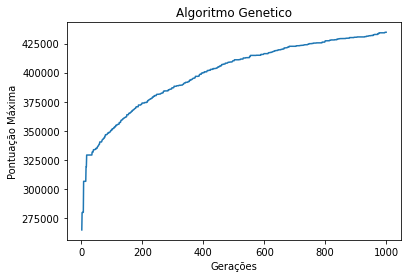

In [ ]:
plt.plot(np.arange(1, 1000 + 1), iter_score)
plt.title("Algoritmo Genetico")
plt.xlabel("Gerações")
plt.ylabel("Pontuação Máxima")
plt.show()

In [ ]:
#depots_adj

In [ ]:
#depots_list

## **Hiperparâmetros**

### **Coeficientes de Mutação**

Os coeficientes de mutação são essencias para o desempenho do algoritmo, escolhas de coeficientes pequenos podem fazer o algoritmo atingir resultados melhores contudo demoram mais para converger.

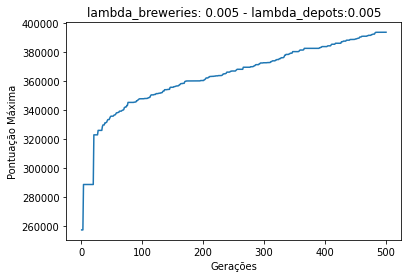

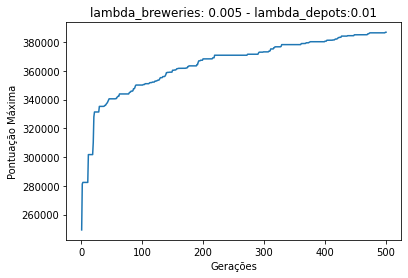

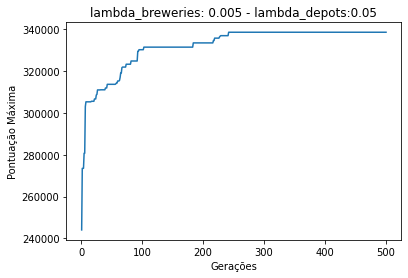

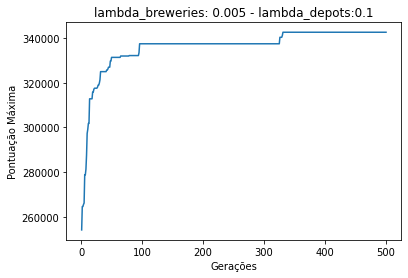

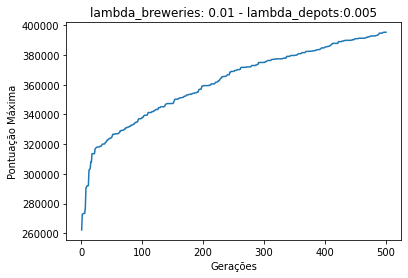

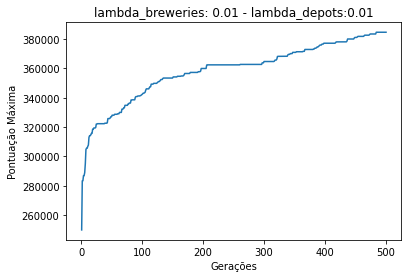

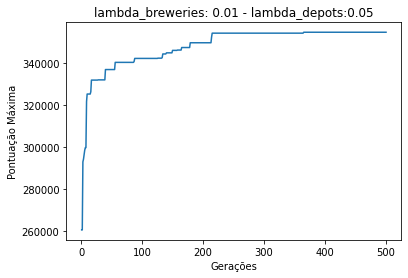

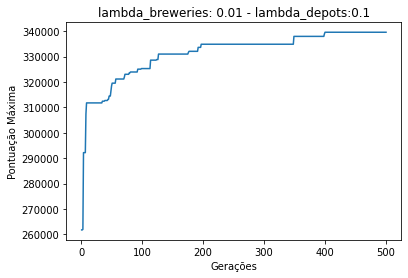

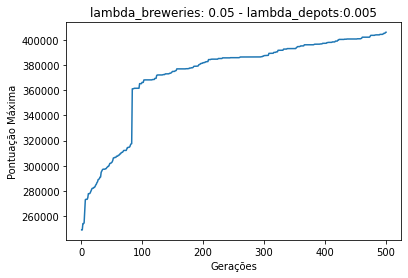

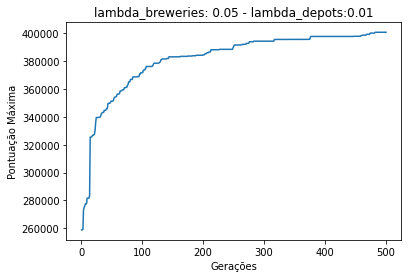

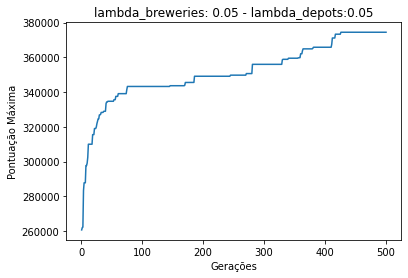

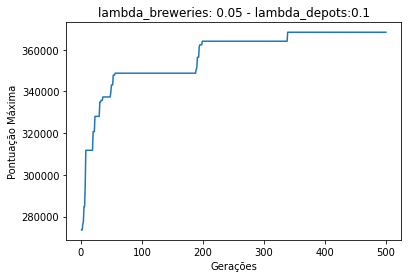

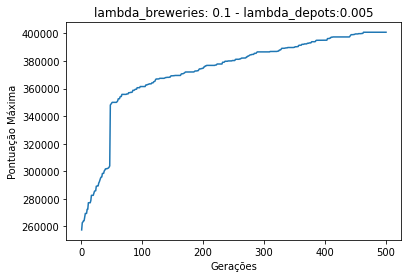

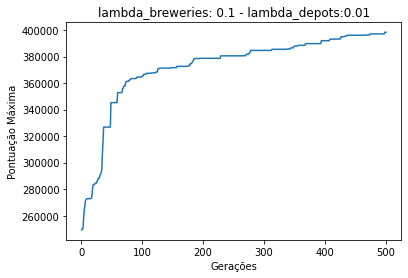

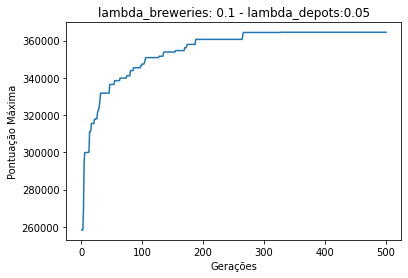

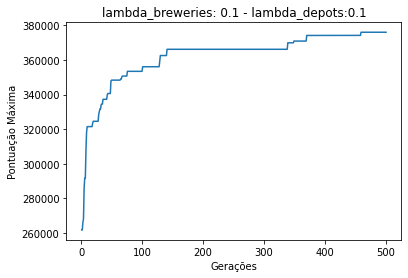

In [ ]:
lambda_values = [0.005, 0.01, 0.05, 0.1]

for lambda_breweries in lambda_values:
  for lambda_depots in lambda_values: 
    best, record, depots_adj, depots_list, iter_score  = optimizeStock("85021", max_iter=500, size=50, lambda_breweries=lambda_breweries, lambda_depots=lambda_depots)
    plt.plot(np.arange(1, 500 + 1), iter_score)
    plt.title("lambda_breweries: " + str(lambda_breweries) + " - lambda_depots:"  + str(lambda_depots))
    plt.xlabel("Gerações")
    plt.ylabel("Pontuação Máxima")
    plt.show()

### **Penalização de Rotas**

Ao reduzir o coeficiente de penalização de rotas é possivel visualizar que a pontuação do melhor cromossomo aumenta. Contudo isso não quer dizer que essas soluções são melhores, pois utilizam de rotas que podem levar a um grande custo de transporte.

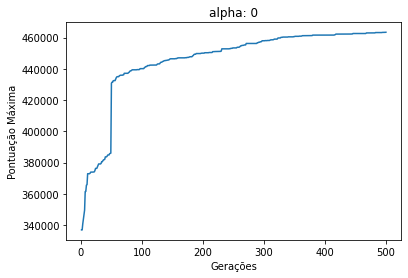

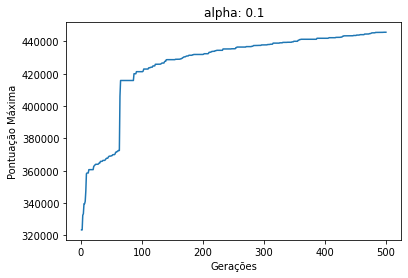

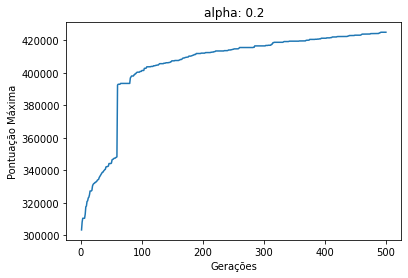

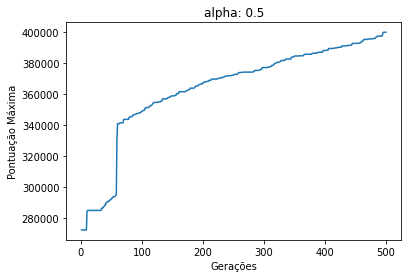

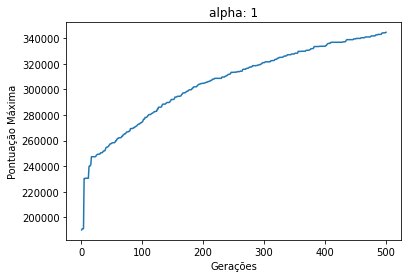

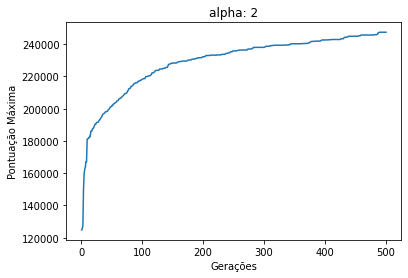

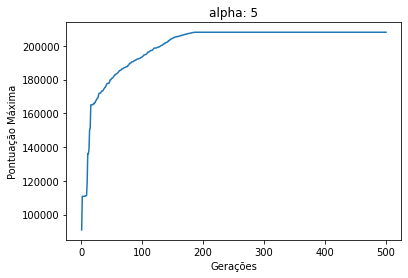

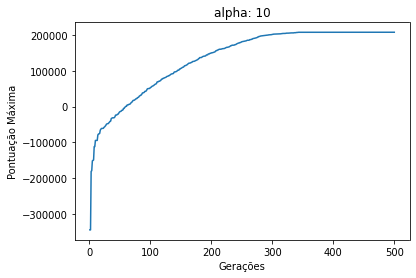

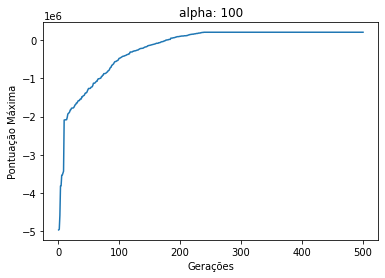

In [ ]:
alpha_values = [0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100]

for alpha in alpha_values:
  best, record, depots_adj, depots_list, iter_score  = optimizeStock("85021", max_iter=500, size=50, alpha=alpha, lambda_breweries=0.005, lambda_depots=0.005)
  plt.plot(np.arange(1, 500 + 1), iter_score)
  plt.title("alpha: " + str(alpha))
  plt.xlabel("Gerações")
  plt.ylabel("Pontuação Máxima")
  plt.show()